# Mustererkennung – Aufgabenblatt 11

Bei Fragen: [florian.hartmann@fu-berlin.de](mailto:florian.hartmann@fu-berlin.de?subject=[Mustererkennung]) – E-Mail-Titel der mit [ME] oder [Mustererkennung] anfängt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.7)

## Daten laden

Wenn man die auf dem Aufgabenblatt verlinkte pickle-Datei benutzt, kann man die Daten so laden:

In [3]:
import pickle

In [4]:
data_path = "data/mnist/mnist.pkl"

In [5]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = pickle.load(open(data_path))

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist/mnist.pkl'

Die Daten sind bereits ausreichend normalisiert.

In [109]:
train = pd.read_table('zip.train', delim_whitespace=True,header=None)
test = pd.read_table('zip.test', delim_whitespace=True,header=None)

#split labels y from data X
y_train = train[0].as_matrix().astype(int)
y_tt = train[0].as_matrix()
X_train = train.drop(0, axis=1).as_matrix()
m = X_train.mean()
X_train = X_train - m

y_test = test[0].as_matrix().astype(int)
X_test = test.drop(0, axis=1).as_matrix() - m

y_val= y_test
X_val = X_test

In [110]:
X_test.mean()

0.026256896424091725

## Allgemeine Klasse für Klassifizierer

In [6]:
class Classifier:
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def confusion_matrix(self, X, y):
        size = len(set(y))
        predicted = self.predict(X)
        
        results = np.zeros((size, size), dtype=np.int32)

        for pi, yi in zip(predicted, y):
            results[int(pi)][int(yi)] += 1

        return results

## Hilfsfunktionen

Als Aktivierungsfunktion benutzen wir zunächst die logistische Funktion. Später im Semester werden wir noch ReLUs (rectified linear units) sehen.

In [120]:
class activation_funct(object):
    def __call__(self,x):
        pass
    def deriv(self,last_output):
        pass
    

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return

In [141]:
def reLu(x):
    x[x<0] = 0
    return x

class ReLu(activation_funct):
    def __call__(self,x):
        x[x<0] = 0
        return x
    def deriv(self,last_output):
        return (last_output >= 0).astype(float)
    
class Sigmoid(activation_funct):
    def __call__(self,x):
        return 1 / (1 + np.exp(-x))
    
    def deriv(self,last_output):
        return last_output * (1 - last_output)

In [147]:
x = Sigmoid()

In [149]:
x(1)

0.7310585786300049

Um die Bias-Einheiten einfacher zu handhaben, werden zwei Hilfsfunktionen benötigt.

In [10]:
def add_ones(X):
    if len(X.shape) == 1:
        return np.c_[[1], [X]][0]
    else:
        return np.c_[np.ones(len(X)), X]

In [11]:
def without_ones(X):
    return X[1:, :]

Da das Modell zwischen 10 Klassen unterscheiden soll, die keine natürliche Ordnung haben, müssen wir die Ausgabe als Vektor darstellen.
In der Statistik nennt man solche Variablen (labels) kategorisch.

In [12]:
def encode_onehot(y):
    output_dimension = len(set(y))
    t = np.zeros((len(y), output_dimension))

    for i, yi in enumerate(y):
        t[i][yi] = 1.

    return t

Alternativ geht es mit numpy kürzer aber weniger verständlich:

In [23]:
def encode_onehot(y):
    output_dimension = len(set(y))
    return np.eye(output_dimension)[y]

## Gradient Descent

Es gibt viele verschiedene Optimierungsalgorithmen, die die Aktualisierungsregel anpassen. Um diese einfach austauschen zu können, abstrahieren dies die meisten ML-Bibliotheken etwas. Eine eigene Klasse sieht vielleicht zunächst übertrieben aus, es macht aber viel Sinn, wenn man etwas kompliziertere Aktualisierungsregeln betrachtet (z.B. RProp).

In [13]:
class GradientDescent:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def __call__(self, weights, gradients, _):
        return weights - self.learning_rate * gradients

Wie beim Aufgabenblatt zur logistischen Regression gesehen, kann es Sinn machen die Lernrate dynamisch sinken zu lassen.

In [14]:
class DecayedGradientDescent:
    def __init__(self, learning_rate, decay):
        self.learning_rate = learning_rate
        self.decay = decay
        self.last_epoch = -1
        
    def __call__(self, weights, gradients, epoch):
        result = weights - self.learning_rate * gradients
        
        if epoch != self.last_epoch:
            self.learning_rate = self.learning_rate * 1 / (1 + self.decay * epoch)
            self.last_epoch = epoch
            
        return result

## Neuronale Netze

In [15]:
from operator import itemgetter
from random import sample
from time import time

Die folgende Klasse implementiert neuronale Netze mit mini-batch gradient descent. In jeder Iteration werden dabei `batch_size` viele zufällige Datenpunkte ausgesucht und durch das Netz geschickt. Bei `batch_size=1` entspricht das stochastic gradient descent (SGD), bei `batch_size=len(X)` wäre es einfach normaler batch gradient descent.

Nach jeder Epoche wird die Klassifikationsgenauigkeit ausgegeben. Man unterscheidet oft zwischen Epochen und Iterationen:
- Epochen geben an wie oft man durch den gesamten Trainingsdatensatz gegangen ist
- Iterationen sind abhängig vom konkreten Algorithmus (SGD, mini-batch -, batch gradient descent) und bezeichnen einfach die Durchläufe der jeweiligen Schleife

In [173]:
class NeuralNetwork(Classifier):
    def __init__(self, hidden):
        self.hidden = hidden

    def fit(self, X, y, activation, optimizer, epochs=10, test=None, batch_size=128):
        _, input_dimension = X.shape
        output_dimension = len(np.unique(y))
        self.output_dimension = output_dimension
        self.activation = activation
        t = encode_onehot(y)
        self._init_weights(input_dimension, output_dimension)
                
        batch_size = min(len(X), batch_size)
        data = list(zip(X, t))
        
        train_history = []
        test_history = []
        
        best_test = best_iteration = 0
        
        for i in range(epochs):
            t = time()
            
            for _ in range(int(len(X) / batch_size)):
                for Xi, ti in sample(data, batch_size):
                    Os = self._feed_forward(Xi)
                    gradients = self._back_propagate(Os, ti)
                    self.W = optimizer(self.W, gradients, i)

            score = self.score(X, y)
            train_history.append(score)
            output = "Epoch %d/%d: %ds – training %.5f" % (i + 1, epochs, time() - t, score)
            
            if test is not None:
                score = self.score(*test)
                test_history.append(score)
                output += " – validation %.5f" % score
                
                if score > best_test:
                    best_test = score
                    best_iteration = i
                
            print(output)
        
        if test is not None:
            print("=> Best validation accuracy was %.5f at iteration %d" % (best_test, best_iteration + 1))
                    
        return train_history, test_history
    
    def _init_weights(self, input_dimension, output_dimension):
        self.W = []
        previous_dimension = input_dimension
        
        for layer in self.hidden + [output_dimension]:
            self.W.append(self._init_layer(previous_dimension, layer))
            previous_dimension = layer
        
    def _init_layer(self, input_dim, output_dim):
        if type(self.activation) == type(ReLu()):
            return np.random.normal(0,2/(input_dim),(input_dim + 1, output_dim))
        return np.random.normal(0,2/(input_dim+output_dim),(input_dim + 1, output_dim)) #np.random.normal(0,2/(input_dim+output_dim),(input_dim + 1, output_dim)) #np.random.random((input_dim + 1, output_dim)) - 0.5
    
    def _feed_forward(self, X):
        activation = self.activation
        
        Os = [X]
        O_last = X
        
        for Wi in self.W:
            O_hat = add_ones(O_last)
            O_last = activation(O_hat.dot(Wi))#sigmoid(O_hat.dot(Wi))
            Os.append(O_last)
            
        return Os
    
    def _back_propagate(self, Os, ti):
        activation = self.activation
        gradients = []

        # Output layer
        O_last = Os[-1]
        O_last_prev = Os[-2]
        
        e = O_last - ti
        D = np.diag(activation.deriv(O_last))#O_last * (1 - O_last))
        delta = D.dot(e)
        
        gradients.append(np.outer(delta, add_ones(O_last_prev)).T)

        # Hidden layers
        for i in reversed(range(1, len(self.hidden) + 1)):
            O = Os[i]
            #print(O)
            D = np.diag(activation.deriv(O))# O * (1 - O))

            delta = D.dot(without_ones(self.W[i])).dot(delta)
            gradients.append(np.outer(delta, add_ones(Os[i - 1])).T)
            
        return np.array(gradients)[::-1]
    
    def predict(self, X):
        O_last = self._feed_forward(X)[-1]
        return O_last.argmax(axis=1)

## Visualisierung

In [136]:
def plot(history, start=1):
    acc = history[0][start:]
    val_acc = history[1][start:]
    
    x = range(len(acc))
    
    fig = plt.figure(figsize=(25, 20))
    plt.subplot(2, 1, 1)
    
    plt.plot(x, acc, label='Training Accuracy')
    plt.plot(x, val_acc, label='Validation Accuracy')
    plt.axvline(x=np.argmax(val_acc) + start, color="grey", alpha=.6, label="Best Validation", linestyle="--")
    
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    
    plt.xlim(1)
    plt.show()

## Aufgabe 1: MNIST

### 80 Neuronen, 0.2 Lernrate

In [176]:
clf = NeuralNetwork(hidden=[40,20])
history = clf.fit(X_train, y_train, activation=ReLu(), optimizer=GradientDescent(learning_rate=.005), epochs=20, test=(X_val, y_val))
clf.score(X_test, y_test)

Epoch 1/20: 3s – training 0.92662 – validation 0.88042
Epoch 2/20: 3s – training 0.93924 – validation 0.88789
Epoch 3/20: 3s – training 0.94308 – validation 0.89537
Epoch 4/20: 3s – training 0.94857 – validation 0.89487
Epoch 5/20: 3s – training 0.95296 – validation 0.90284
Epoch 6/20: 3s – training 0.95529 – validation 0.90234
Epoch 7/20: 3s – training 0.95296 – validation 0.90732
Epoch 8/20: 3s – training 0.95296 – validation 0.90135
Epoch 9/20: 3s – training 0.95131 – validation 0.89287
Epoch 10/20: 3s – training 0.94143 – validation 0.89387
Epoch 11/20: 3s – training 0.93677 – validation 0.88939
Epoch 12/20: 3s – training 0.92456 – validation 0.87593
Epoch 13/20: 3s – training 0.89878 – validation 0.85252


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:1154: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:1154: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


Epoch 14/20: 3s – training 0.16376 – validation 0.17887
Epoch 15/20: 3s – training 0.16376 – validation 0.17887
Epoch 16/20: 3s – training 0.16376 – validation 0.17887
Epoch 17/20: 3s – training 0.16376 – validation 0.17887
Epoch 18/20: 3s – training 0.16376 – validation 0.17887
Epoch 19/20: 3s – training 0.16376 – validation 0.17887
Epoch 20/20: 3s – training 0.16376 – validation 0.17887
=> Best validation accuracy was 0.90732 at iteration 7


0.17887394120577976

In [169]:
x = ReLu()

type(x)

__main__.ReLu

In [156]:
clf = NeuralNetwork(hidden=[70,40])
history = clf.fit(X_train, y_train, activation=Sigmoid(), optimizer=GradientDescent(learning_rate=.3), epochs=20, test=(X_val, y_val))
clf.score(X_test, y_test)

Epoch 1/20: 3s – training 0.68523 – validation 0.64773
Epoch 2/20: 3s – training 0.93458 – validation 0.88739
Epoch 3/20: 3s – training 0.95570 – validation 0.91081
Epoch 4/20: 3s – training 0.96228 – validation 0.90782
Epoch 5/20: 3s – training 0.97175 – validation 0.91679
Epoch 6/20: 3s – training 0.97710 – validation 0.92476
Epoch 7/20: 3s – training 0.98176 – validation 0.92476
Epoch 8/20: 3s – training 0.98450 – validation 0.92725
Epoch 9/20: 3s – training 0.98670 – validation 0.92576
Epoch 10/20: 3s – training 0.99012 – validation 0.92925
Epoch 11/20: 3s – training 0.99095 – validation 0.93124
Epoch 12/20: 3s – training 0.99218 – validation 0.93024
Epoch 13/20: 3s – training 0.99273 – validation 0.92825
Epoch 14/20: 3s – training 0.99314 – validation 0.93174
Epoch 15/20: 3s – training 0.99355 – validation 0.93074
Epoch 16/20: 3s – training 0.99424 – validation 0.93224
Epoch 17/20: 3s – training 0.99438 – validation 0.93124
Epoch 18/20: 3s – training 0.99465 – validation 0.93224
E

0.93273542600896864

### 80 Neuronen, 0.5 Lernrate

In [157]:
clf = NeuralNetwork(hidden=[80])
history = clf.fit(X_train, y_train, activation=Sigmoid(), optimizer=GradientDescent(learning_rate=.3), epochs=20, test=(X_val, y_val))
clf.score(X_test, y_test)

Epoch 1/20: 2s – training 0.94596 – validation 0.89836
Epoch 2/20: 2s – training 0.96393 – validation 0.91281
Epoch 3/20: 2s – training 0.97435 – validation 0.92277
Epoch 4/20: 2s – training 0.97545 – validation 0.92377
Epoch 5/20: 2s – training 0.98176 – validation 0.92875
Epoch 6/20: 3s – training 0.98491 – validation 0.92925
Epoch 7/20: 2s – training 0.98711 – validation 0.93722
Epoch 8/20: 2s – training 0.98930 – validation 0.93323
Epoch 9/20: 2s – training 0.98999 – validation 0.93622
Epoch 10/20: 2s – training 0.99204 – validation 0.93921
Epoch 11/20: 2s – training 0.99273 – validation 0.93921
Epoch 12/20: 2s – training 0.99314 – validation 0.93921
Epoch 13/20: 2s – training 0.99410 – validation 0.94021
Epoch 14/20: 2s – training 0.99410 – validation 0.94121
Epoch 15/20: 2s – training 0.99438 – validation 0.94021
Epoch 16/20: 2s – training 0.99451 – validation 0.93921
Epoch 17/20: 2s – training 0.99424 – validation 0.93672
Epoch 18/20: 2s – training 0.99438 – validation 0.94071
E

0.93821624314897856

Wenn man lange genug trainiert und genug Neuronen hat, geht die Trainingsgenauigkeit oft sehr nah an 100% heran. Die Testgenauigkeit verbessert sich aber irgendwann nicht mehr, da die Trainingsdaten zu genau gelernt werden. Im schlimmsten Fall wird die Testgenauigkeit dann sogar wieder schlechter.

Eine beliebte Strategie dagegen ist *early stopping*: Man betrachtet die Genauigkeit einer weiteren nicht zum Training benutzter Menge (der Validierungsmenge). Sobald sich diese Genauigkeit nicht mehr verbessert, bricht man ab und nimmt das Modell mit der besten Validierungsgenauigkeit.

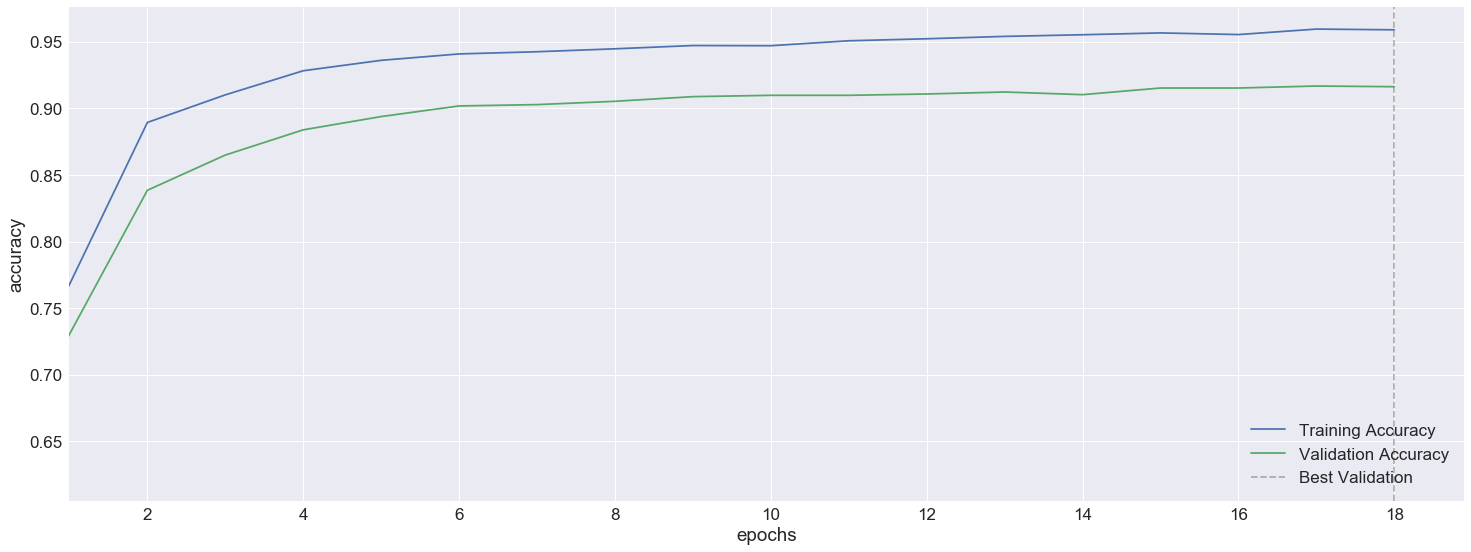

In [161]:
plot(history)

### 70, 50 Neuronen, 0.4 Lernrate

In [116]:
clf = NeuralNetwork(hidden=[70, 50])
history = clf.fit(X_train, y_train, optimizer=GradientDescent(learning_rate=.004), epochs=20, test=(X_val, y_val))
clf.score(X_test, y_test)

Epoch 1/20: 3s – training 0.87697 – validation 0.82860
Epoch 2/20: 3s – training 0.93732 – validation 0.89138
Epoch 3/20: 3s – training 0.94651 – validation 0.90433
Epoch 4/20: 3s – training 0.94939 – validation 0.90782
Epoch 5/20: 3s – training 0.95145 – validation 0.90483
Epoch 6/20: 3s – training 0.95707 – validation 0.91031
Epoch 7/20: 3s – training 0.96201 – validation 0.91829
Epoch 8/20: 3s – training 0.96269 – validation 0.91231
Epoch 9/20: 3s – training 0.96626 – validation 0.91629
Epoch 10/20: 3s – training 0.96695 – validation 0.91679
Epoch 11/20: 3s – training 0.97188 – validation 0.91978
Epoch 12/20: 3s – training 0.96681 – validation 0.91430
Epoch 13/20: 3s – training 0.96777 – validation 0.92028
Epoch 14/20: 3s – training 0.96887 – validation 0.92227
Epoch 15/20: 3s – training 0.96941 – validation 0.91779
Epoch 16/20: 3s – training 0.97010 – validation 0.91679
Epoch 17/20: 3s – training 0.96914 – validation 0.91679
Epoch 18/20: 3s – training 0.96941 – validation 0.91330
E

0.91828599900348784

### 70, 50 Neuronen, 0.2 Lernrate

In [67]:
clf = NeuralNetwork(hidden=[70, 50])
history = clf.fit(X_train, y_train, optimizer=GradientDescent(learning_rate=.2), epochs=20, test=(X_val, y_val))
clf.score(X_test, y_test)

ValueError: shapes (50,) and (10,) not aligned: 50 (dim 0) != 10 (dim 0)

## Aufgabe 2: Logische Funktionen

In [242]:
X_bin = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

y_and = [a & b for a, b in X_bin]
y_or = [a | b for a, b in X_bin]
y_xor = [a ^ b for a, b in X_bin]

Bei or und and brauchen wir keine hidden layers, da die Datensätze perfekt linear separierbar sind.

In [299]:
clf = NeuralNetwork(hidden=[])
clf.fit(X_bin, y_or, epochs=5, optimizer=GradientDescent(learning_rate=5.))
clf.score(X_bin, y_or)

Epoch 1/5: 0s – training 0.75000
Epoch 2/5: 0s – training 0.75000
Epoch 3/5: 0s – training 0.75000
Epoch 4/5: 0s – training 0.75000
Epoch 5/5: 0s – training 1.00000


1.0

In [305]:
clf = NeuralNetwork(hidden=[])
clf.fit(X_bin, y_and, epochs=5, optimizer=GradientDescent(learning_rate=5.))
clf.score(X_bin, y_and)

Epoch 1/5: 0s – training 0.75000
Epoch 2/5: 0s – training 0.75000
Epoch 3/5: 0s – training 0.75000
Epoch 4/5: 0s – training 0.75000
Epoch 5/5: 0s – training 1.00000


1.0

Bei xor benötigen wir auch Neuronen in hidden layers. Dafür können wir hier nun auch 100% erreichen.

In [41]:
clf = NeuralNetwork(hidden=[10])
clf.fit(X_bin, y_xor, epochs=1000, optimizer=GradientDescent(learning_rate=.5))
clf.score(X_bin, y_xor)

NameError: name 'X_bin' is not defined

In [45]:
(np.eye(4) >= 0).astype(float)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [49]:
x = np.eye(5)

In [50]:
np.max(0,x)

TypeError: only integer scalar arrays can be converted to a scalar index

In [66]:
reLu(x+10)

array([[ 11.,  10.,  10.,  10.,  10.],
       [ 10.,  11.,  10.,  10.,  10.],
       [ 10.,  10.,  11.,  10.,  10.],
       [ 10.,  10.,  10.,  11.,  10.],
       [ 10.,  10.,  10.,  10.,  11.]])